In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

# Exercise 08.1

The goal of this exercise is to find an estimate of the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

As this model is not analytically solvable, we will use a variational Monte Carlo method.

We recall that the variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

In order to obtain a satisfactory approximation for ground state energy, a "good" trial wave function needs to be chosen. In this case, an approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

which depends on two variational parameters: $\sigma$ and $\mu$.

### Sampling the wavefunction

First, we need to implement the Metropolis algorithm in order to sample the wavefunction.
It will use the following features:
- a uniform transition probability. At each step the value of $x$ will be modified by adding a random value in range $[-\delta, +\delta]$, where $\delta$ is a number set in a way that the resulting acceptance rate is close to 50%.
- probabilty $min(1, (\frac{\psi(x_{new})}{\psi(x)})^2)$ of updating the current position from $x$ to $x_{new}$ (generated as explained right above)

Furthermore, it is important to observe that in this case a "standard" Metropolis algorithm may not be able to explore the space properly, since the shape of the wavefunction makes it difficult (or impossible) for the algorithm to cross the "barrier" between the two peaks, possibly resulting in an uneven sampling.

To overcome this issue, a "trick" has been implemented: every 10 Metropolis steps, the algorithm will forcefully "flip" the value of x (does not count as an actual Metropolis step) $$ x_{new}=-x_{old}$$
This modification to the Metropolis algorithm will not interfere with the exploration of the position space, as the wavefunction is symmetrical with respect to the origin.

The resulting mapping of the probability distribution $|\psi_T|^2$ with parameteres $\mu =1$, $\sigma=0.5$ is shown in the histogram below.

In [3]:
sampled=np.loadtxt('../es8/es8_1/OUTPUT/metro.dat')

def Psi_trial(x, mu, sigma):
    return 1/(np.sqrt(np.pi)) * (np.exp(-(x-mu)**2/(2*sigma**2))+np.exp((-(x+mu)**2/(2*sigma**2))))**2

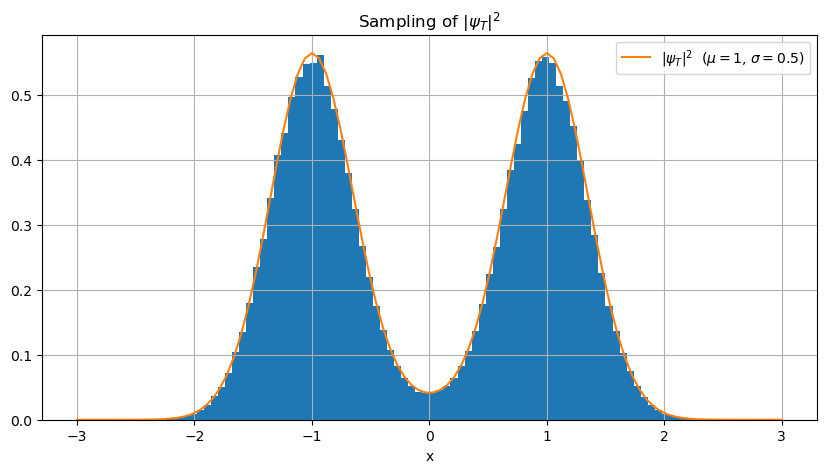

In [25]:
plt.figure(figsize = (10,5))
plt.hist(sampled, range=(-3, 3), density = True, bins=100)
x=np.linspace(-3,3,100)
plt.plot(x, Psi_trial(x, 1., 0.5), label='$|\psi_T|^2$  ($\mu =1$, $\sigma=0.5$)')
plt.xlabel('x')
plt.legend(loc="upper right")
plt.title('Sampling of $|\psi_T|^2$')
plt.grid(True)
plt.show()

### Computing the energy

By using data blocking, the code will compute the expected value of the Hamiltonian:
    
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

With the Metropolis algorithm implemented as discussed above, we will only need to compute the value of
$$
\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$
for the values of $x$ sampled from the correct probability distribution.

In [14]:
energy, err=np.loadtxt('../es8/es8_1/OUTPUT/energy.dat', usecols=(0,1), unpack=True)
blocks=np.linspace(1,energy.size, energy.size)

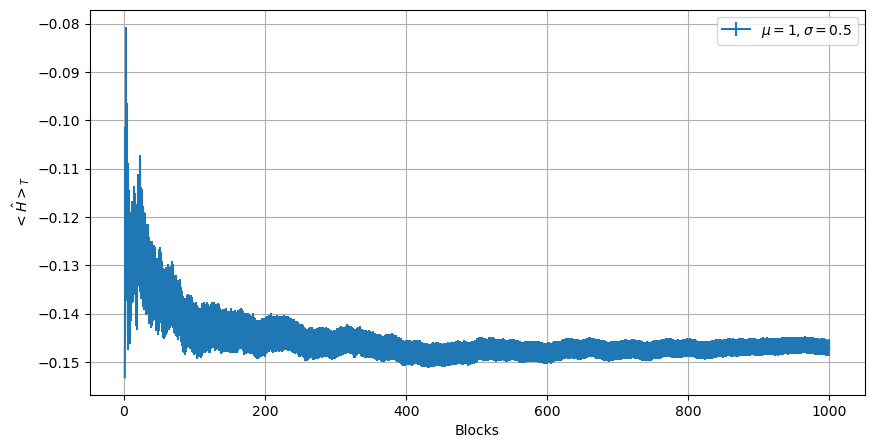

Energy average: -0.146998 +- 0.00169384


In [66]:
plt.figure(figsize = (10,5))
plt.errorbar(blocks, energy, err, label='$\mu =1, \sigma=0.5$')
plt.xlabel('Blocks')
plt.ylabel('$ < {\hat H} > _T $')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("Energy average: " + str(energy[-1]) + " +- " + str(err[-1]))

# Exercise 08.2

By means of Simulated Annealing, we are going to minimize the parameters $\mu, \sigma$ to find a suitable approximation for the ground state energy of a particle subject to the potential $V(x)$.

### Simulated Annealing

The algorithm works as follow:
1) a certain temperature and set of parameters are set. In this case , a starting temperature of 2 has been chosen, as well as starting parameters $\mu=0.8, \sigma=0.6$.
2) A new set of parameters is proposed. These new parameters will be: $$p_{new}= p_{old} + 0.05r$$ where $p$ is $\sigma$ or $\mu$ and $r$ is a random number in the range (-1,1). Other choices could be made, for instance one could make the perturbation to $p_{old}$ depend on the temperature.
3) A Metropolis acceptation step is made with probability $$min(1, exp(\frac{-(E_{new}-E))}{T}))$$, where $E_{new}$ and $E$ are the energies ($\langle \hat H \rangle_T$) of the wavefunction set with the "new" and current sets of parameters respectively.
4) If the proposed "step" is accepted, the wavefunction parameteres are updated to be the proposed "new" ones.
5) The temperature of the system is decreased as $T_{new}= T*0.997$ and the algorithm repeats from step 2.
6) When a threshold temperature has been reached, the algorithm stops. Here $T_{target}=0.01$.

With this setup, when the temperature is high enough, the probability of accepting a step, even when energetically not convenient, is relatively high, thus allowing "free" exploration of the parameter space increasing the likelihood of finding a global minimum. As the temperature is decreased, the algorithm settles inside a minimum.

The graph below shows the result of a SA operated with the features described above. It shows all the poins explored in the parameter space with the color indicating the energy value: the more dark blue, the lower the energy.

In [93]:
temp, sigma, mu, H, H_err = np.loadtxt('../es8/es8_2/OUTPUT/SA.dat', usecols=(0,1,2,3, 4), unpack = True)

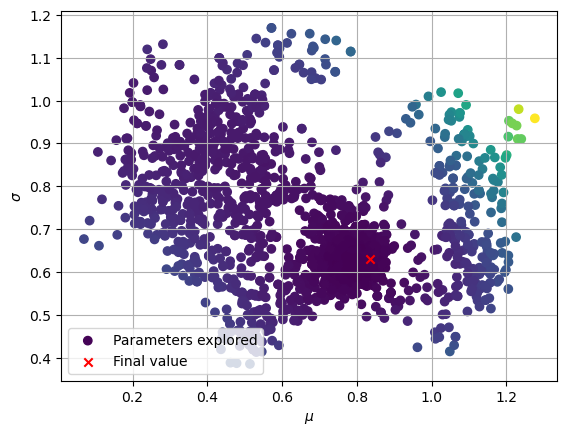

Final values:
Mu: 0.834043
Sigma: 0.631178


In [94]:
plt.scatter(mu, sigma, c=H, label='Parameters explored')
plt.scatter(mu[-1], sigma[-1], color='r', marker='x', label="Final value")
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

print('Final values:\nMu: ' + str(mu[-1]) + '\nSigma: ' + str(sigma[-1]))

Note that the maximum possible update for a parameter is 0.05 for each step.

The graph below shows the evolution of the wavefunction energy through the SA run. It is plotted as function of SA steps and $T$.

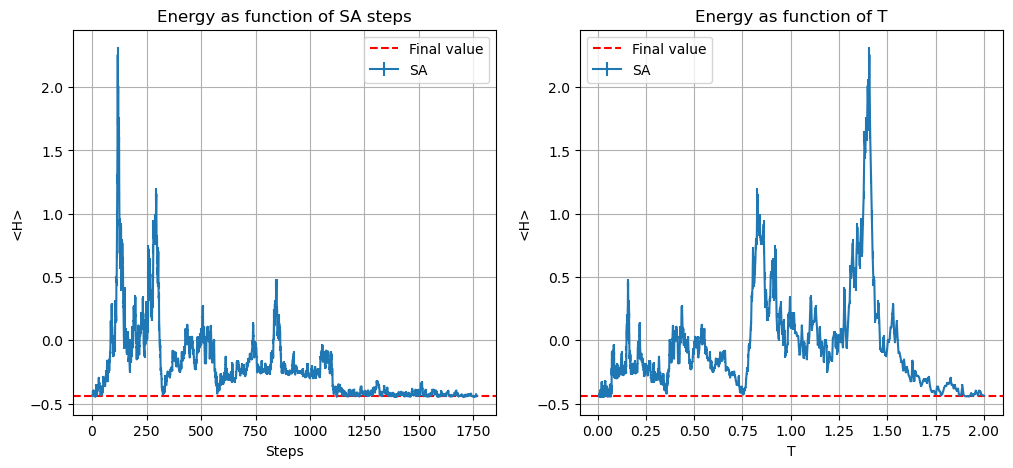

In [96]:
beta=1/temp
steps=np.linspace(1,temp.size, temp.size)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.errorbar(steps, H, H_err, label='SA')
plt.axhline(H[-1], c='r', linestyle='dashed', label='Final value')
plt.xlabel('Steps')
plt.ylabel('<H>')
plt.grid(True)
plt.title('Energy as function of SA steps')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.errorbar(temp, H, H_err, label='SA')
plt.axhline(H[-1], c='r', linestyle='dashed', label='Final value')
plt.xlabel('T')
plt.ylabel('<H>')
plt.grid(True)
plt.title('Energy as function of T')
plt.legend(loc='upper left')

plt.show()

We can now compare the value of ground state energy obtained via SA with the one obtained by diagonalization of the Hamiltonian by discretizing the second derivative.

In [101]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
hbar = 1
m = 1
a = 10
N = 1000 # number of iterations
# Step sizes
x_d = np.linspace(-a/2, a/2, N)
dx = x_d[1] - x_d[0] # the step size
V = Vpot(x_d)
# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal
# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)
# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])

Ground state energy:  -0.46046587969271535


The following is a plot of the energy of the final wavefunction obtained from SA. The computation has been made with data blocking and Metropolis sampling of the wavefunction as described previously.

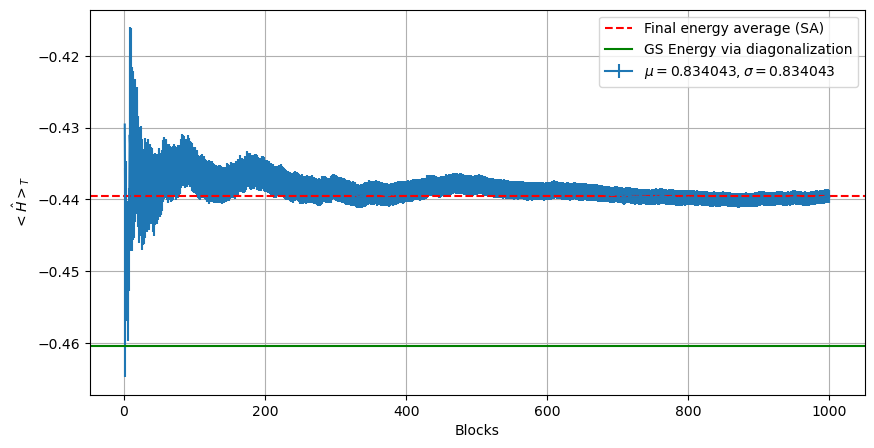

Energy average: -0.439594 +- 0.000952746


In [102]:
blocks, energy, err= np.loadtxt("../es8/es8_2/OUTPUT/energy.dat", usecols=(0,1,2), unpack=True)

plt.figure(figsize = (10,5))
plt.errorbar(blocks, energy, err, label='$\mu =' + str(mu[-1]) + ', \sigma=$' + str(mu[-1]))
plt.axhline(energy[-1], color='r', linestyle='dashed', label='Final energy average (SA)')
plt.axhline(E[0], c='g', label='GS Energy via diagonalization')
plt.xlabel('Blocks')
plt.ylabel('$ < {\hat H} > _T $')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("Energy average: " + str(energy[-1]) + " +- " + str(err[-1]))

Lastly, we plot the final wavefunction by means of Metropolis sampling to compare it with the one obtained with diagonalizing the Hamiltonian.

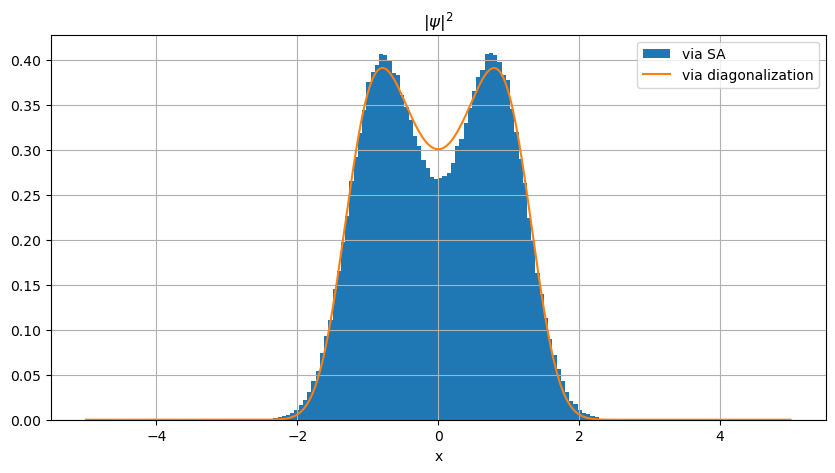

In [111]:
sampled= np.loadtxt("../es8/es8_2/OUTPUT/psi.dat")

plt.figure(figsize = (10,5))
plt.hist(sampled, range=(-3, 3), density = True, bins=100, label='via SA')
plt.plot(x_d,(psi[0])**2, label='via diagonalization')
plt.xlabel('x')
plt.title('$|\psi|^2$')
plt.legend()
plt.grid(True)
plt.show()

From this results we can see how the Simulated Annealing has been succesful in minimizing the parameters $\mu \sigma$ for the trial wavefunction we have chosen. For better results, one should find an even better suited trial wavefunction.